In [19]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from networkx.utils import powerlaw_sequence, random_sequence
from networkx import configuration_model
import scipy
from matplotlib import style
from scipy.interpolate import make_interp_spline, BSpline
import math
import copy
import pandas as pd
from networkx.algorithms.community import k_clique_communities



plt.style.use('ggplot')

In [20]:
"""scale-free network = la probabilità che un nodo abbia grado k è più o meno k^-lambda, lambda parametro"""

"""Name: { 
            generate_scale_free }
   Param: { 
            num_nodes = numero dei nodi sulla rete
            random_edge = numero di edge base che vengono aggiunti a ogni nodo
            prob_trinage = probabiltà oltre agli edge di base di aggiungere un triangolo al nodo
            seed = seed per avere sempre la stessa rete }
   Return: {
            lambda = calcolato sulla base di una media
            graph = il network generato con la power law
            list_deg = lista dei gradi dei nodi in ordine sequenziale }
   """
def generate_scale_free(num_nodes, random_edge, prob_triangle , seed):
    
    graph = nx.powerlaw_cluster_graph(num_nodes, random_edge, prob_triangle, seed) #Holme and Kim algorithm 
    node_degree = list(graph.degree()) #list (node, degree)
    lamda_v = []
    current_edges = 0
    list_deg = []

    for node, degree in node_degree:
        list_deg.append(degree)
    
    mean = scipy.stats.moment(list_deg)
    second_momentum = scipy.stats.moment(list_deg, 2)

    counts = np.bincount(list_deg) #count number of occurrences of each value in array of non-negative ints
    mask = (counts > 0)
    
    '''
    #P(k) = x ^ - lambda
    #log(P(k)) = - lambda * log(x)
    #-lambda = log(P(k)) / log(x)
    #theta_lambda = sum(y_v) / len(lamda_v)
    '''
    #Code for this calculation
    for i in range(0, len(list_deg)):
        for j in range(0, len(counts)):
            if (j == list_deg[i]):
                if (counts[j] > 0):
                    lamda_v.append(np.log(counts[j]) / list_deg[i])
                else:
                    print("wrong")
    lamb = sum(lamda_v) / len(lamda_v)
    
    parameters = graph_parameters(graph)
    parameters = parameters  + (lamb, second_momentum, )



    return (graph, lamb, parameters)

def draw_scale_free_distribution(network):
    num_nodes = len(network)
    node_degree = list(network.degree())  # list (node, degree)
    list_deg = []

    for node, degree in node_degree:
        list_deg.append(degree)
    
    mean = scipy.stats.moment(list_deg)
    second_momentum = scipy.stats.moment(list_deg, 2)

    counts = np.bincount(list_deg)
    mask = (counts > 0)

    plt.plot(np.arange(len(counts))[
             mask], counts[mask] / counts.sum(), "o", label="PowerLaw")
    x = np.arange(1, len(counts))
    plt.plot(x, np.power(x, -lamb))
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num_nodes, lamb))
    plt.legend(loc="best")
    plt.show()


'''create a random network whose degrees follow a poisson distribuition'''
def generate_random_network_poisson(num_nodes, p):
   
    network = nx.erdos_renyi_graph(num_nodes, p) #Returns a Gn,p random graph
    
    list_deg = []
    
    for node, degree in list(network.degree()):
        list_deg.append(degree)
    #print(list_deg)
    counts = np.bincount(list_deg) #Count number of occurrences of each value
    
    parameters = graph_parameters(network)
    #for large X_n the mean of X_n = lamb
    #lamb = sum(counts) / len(counts)
    lamb = sum(list_deg) / len(network.nodes)
    second_momentum = (lamb, lamb + lamb**2)
    parameters = parameters  + (lamb, second_momentum, )

    return (network, lamb, parameters)

def draw_scale_poisson_distribution(network):

    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)

    #print(list_deg)
    counts = np.bincount(list_deg) #Count number of occurrences of each value
    mask = (counts > 0)
    plt.plot(np.arange(len(counts))[mask], counts[mask] / counts.sum(), "o", label="Poisson")
    x = np.arange(1, len(counts))
    lamb = sum(list_deg) / len(network.nodes)
    
    #plt.plot(x, poisson)
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(len(network), lamb))
    plt.legend(loc="best")
    plt.show() 

'''remove one node at random'''
def random_node_removal(network):
    
    lenght_of_list = len(network.nodes)
    value = random.randint(0, lenght_of_list-1)
    nodes = list(network.nodes)
    network.remove_node(nodes[value])
    
    return network

"""rimuovi una percentuale di nodi sul totale della rete"""

def loop_node_removal(network, percentage):

    network_removed = copy.deepcopy(network)
    
    per = round(percentage * len(network_removed.nodes))
    f = []
    P_0 = len(max(nx.connected_components(network_removed), key=len))
    P_inf_devided_P_0 = []
    #probabilità che un nodo all'"epoca" f appartenga al larger component
    # 

    for i in range(0, per):
        network_removed = random_node_removal(network_removed)
        f.append(i)
        P_inf_devided_P_0.append(
            len(max(nx.connected_components(network_removed))) / P_0)
    
    print(f'Eliminated nodes = {per}')
    print(
        f'number of conncted component = {nx.number_connected_components(network_removed)}')

    return (network_removed, P_inf_devided_P_0, f)


"""per calcolare il parametro fc, threshold critico"""

def compute_fc_power_law(network, lamb):
    
    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)

    if (lamb > 3):
        den_1 =  (lamb - 2) / (lamb - 3)
        den = (den_1 * min(list_deg)) - 1
        return 1 - (1 / den)
    else:
        den_1 = (lamb - 2) / ( 3 - lamb )
        den_2 = min(list_deg) ** (lamb - 2)
        den_3 = max(list_deg) ** (3 - lamb)
        den = (den_1 * den_2 * den_3) - 1
        return 1 - (1 / den)

def compute_fc_poisson(network_poisson, lamb):
    #E[K] = lamb
    return 1- (1 / lamb) 

'''plot ratio against f'''
def robustness_plot(network, P_inf_devided_P_0, f):
    xnew = np.linspace(min(f), max(f), 200) 

    #define spline with degree k=7
    spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
    y_smooth = spl(xnew)
    plt.plot(f, P_inf_devided_P_0, linewidth=4)
    #plt.plot([0.05] * len(f), P_inf_devided_P_0)
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.show()


def draw_network(network, size = 2):
    fig = plt.figure(figsize=(20, 10))
    node_color = [float(network.degree(v)) for v in network]
    node_weigth = [float(network.degree(v) ** size) for v in network]
    nx.draw(network,
            node_size = node_weigth,
            pos = nx.spring_layout(network, (1 / len(network) ** (1/5))),
            node_color=node_color,
            width = 0.1,
            with_labels=False)

def graph_parameters(network, lamb = None):
    #for random graphs
    beta = 1
    lamb_p = 1
    nu = 1/2
    tau = 5/2
    if lamb == None:
        return (beta,lamb_p,nu,tau)
    #for scale-free graphs
    if 2<=lamb<3:            
        beta = 1/(3-lamb)
        lamb_p = -1
        nu = (3-lamb)/(lamb-2)
        tau = (2*lamb-3)/(lamb-2)
    elif 3<=lamb<4:          
        beta = 1/(lamb-3)
        nu = (lamb-3)/(lamb-2)
        tau = (2*lamb-3)/(lamb-2)
    return (beta,lamb_p,nu,tau)

In [21]:
# Define networm parameters 
#print("SEED ", seed)
network_size = 1000
print("Network Size ", network_size)

Network Size  1000


Artifical Scale Free Network
Create Network


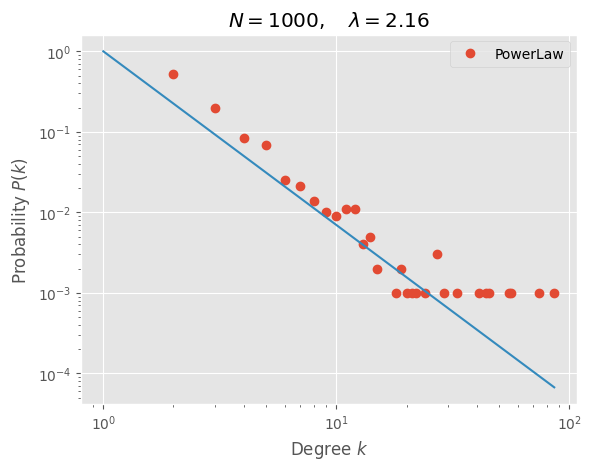

Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 10
Compute robustness network


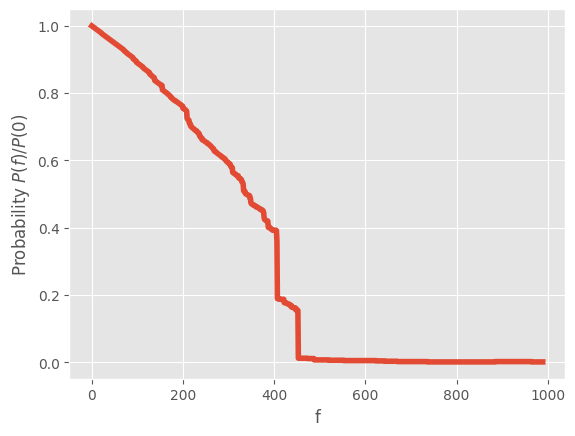

Compute Critical threshold
0.8733377982982048
Draw Network


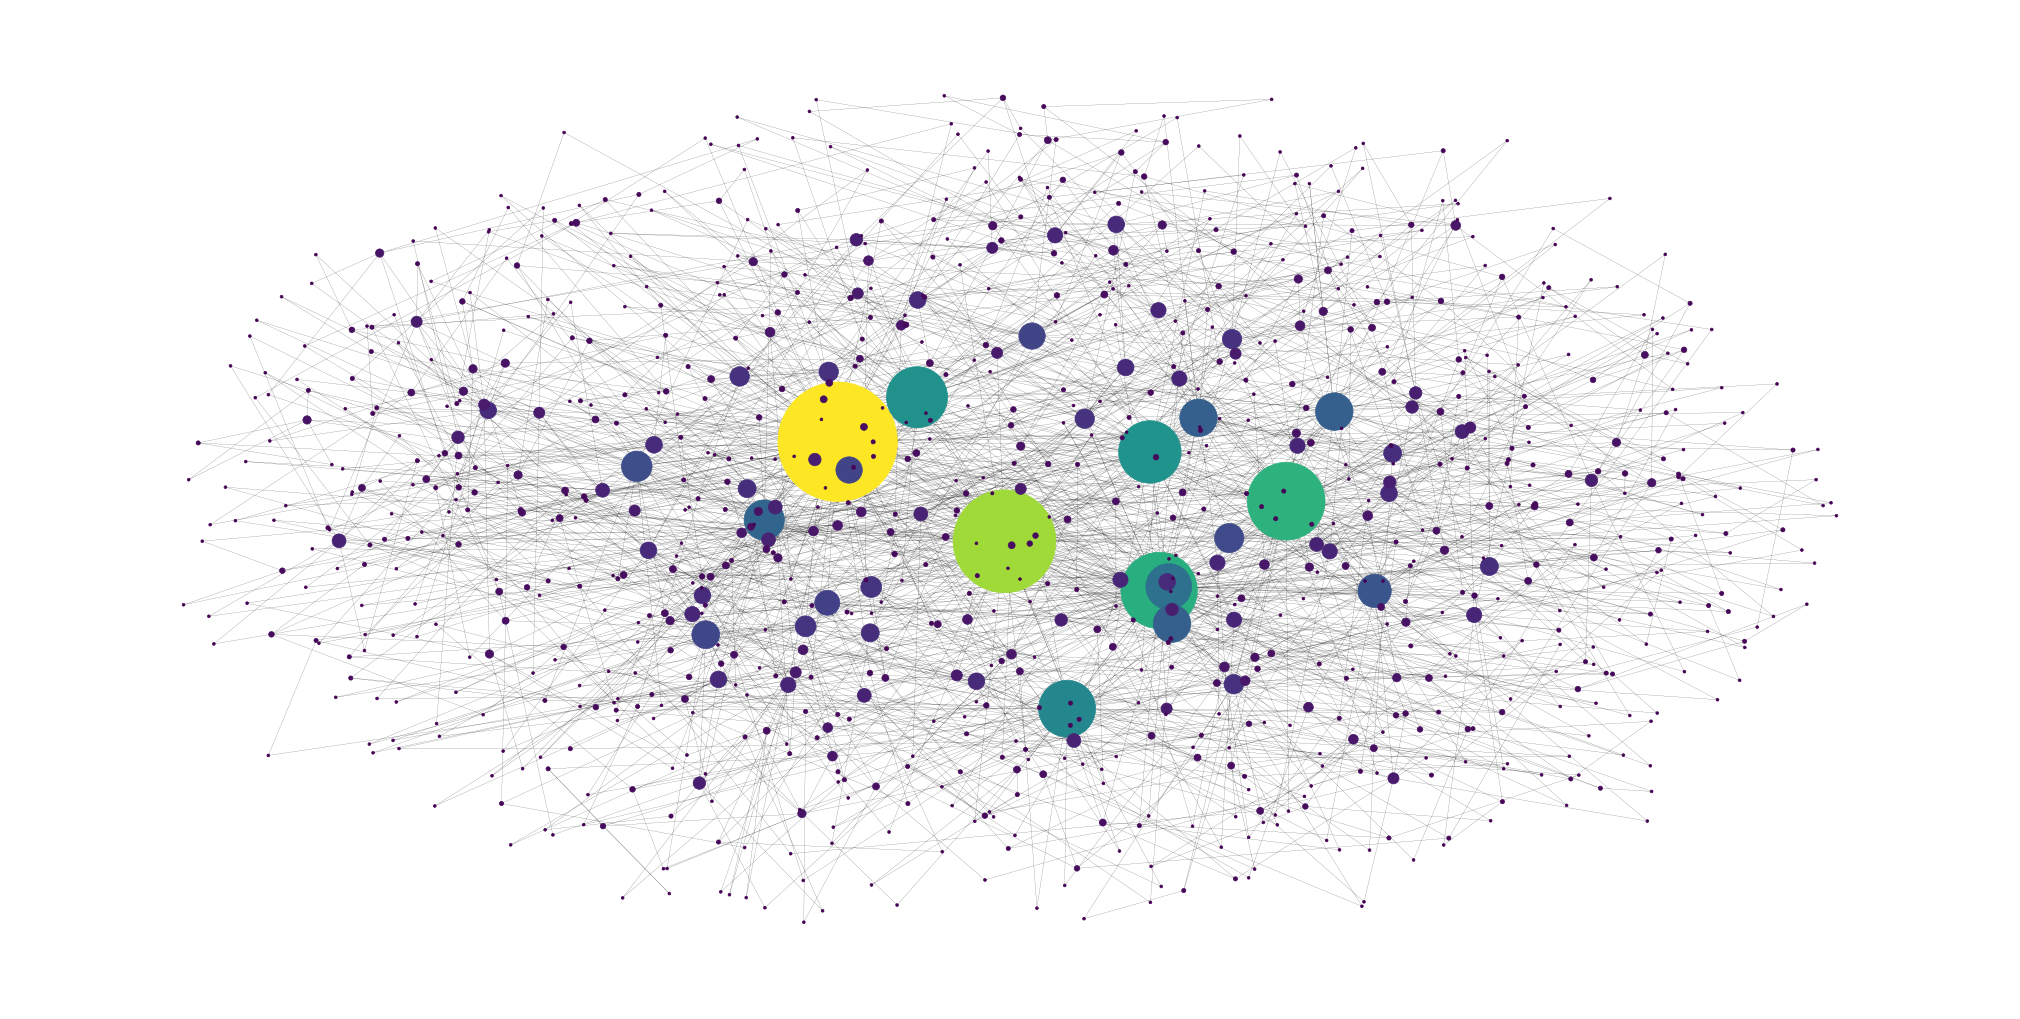

In [22]:
print("Artifical Scale Free Network")
seed = random.randint(0, 100000000000000000)

print("Create Network")
network_scale_free, lamb, params = generate_scale_free(
    network_size, 2, 0.9, seed)
draw_scale_free_distribution(network_scale_free)

#network_removed = percolation_one_node_random(network_scale_free)

print("Simulate random faliures, 99% nodes")
network_removed, P_inf_devided_P_0, f = loop_node_removal(
    network_scale_free, 0.99)

print("Compute robustness network")
robustness_plot(network_scale_free, P_inf_devided_P_0, f)

print("Compute Critical threshold")
fc = compute_fc_power_law(network_scale_free, lamb)
print(fc)

print("Draw Network")
draw_network(network_scale_free)



Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 10
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 10
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 10
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 10
Compute Critical threshold


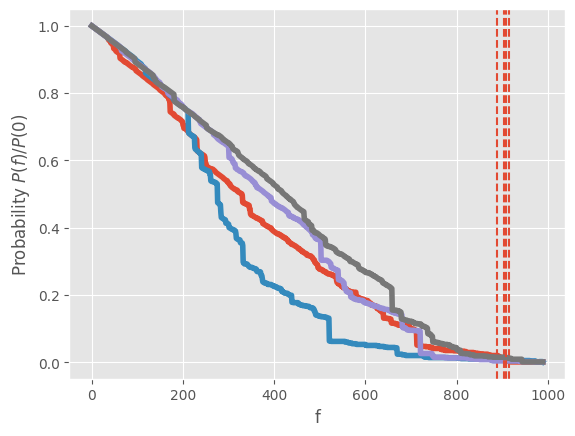

Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
number of conncted component = 20
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
number of conncted component = 20
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
number of conncted component = 20
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 1980
number of conncted component = 20
Compute Critical threshold


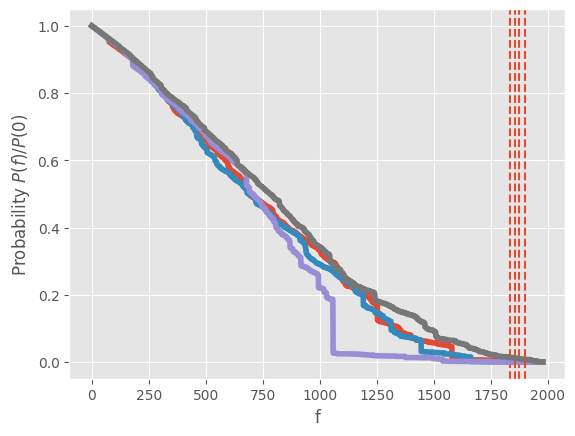

Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
number of conncted component = 49
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
number of conncted component = 49
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
number of conncted component = 49
Compute Critical threshold
Create Network
Simulate random faliures, 99% nodes
Eliminated nodes = 4950
number of conncted component = 49
Compute Critical threshold


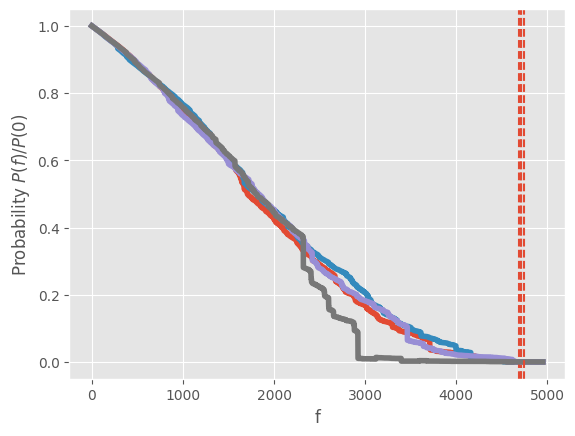

In [23]:
ratios={}
for size in [1000, 2000, 5000]:
    ratios[size] = {}
    ratio = ratios[size]
    ratio["lamb"] = []
    ratio["params"] = []
    ratio["P_inf"] = []
    ratio["fc"] = []
    for i in range(4):
        seed = random.randint(0, 100000000000000000)
        print("Create Network")        
        network_scale_free, lamb, params = generate_scale_free(
            size, 2, 0.9, seed)
        ratio["lamb"].append(lamb)
        ratio["params"].append(params)

        print("Simulate random faliures, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_node_removal(
            network_scale_free, 0.99)
        
        ratio["P_inf"].append(P_inf_devided_P_0)

        print("Compute Critical threshold")
        fc = compute_fc_power_law(network_scale_free, lamb)
        ratio["fc"].append(fc)
        xnew = np.linspace(min(f), max(f), 200)

        #define spline with degree k=7
        spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
        y_smooth = spl(xnew)
        plt.plot(f, P_inf_devided_P_0, linewidth=4)
        plt.axvline(x=max(f)*fc, linestyle='--')
    
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.show()




Artificial Random Network
Generate random network


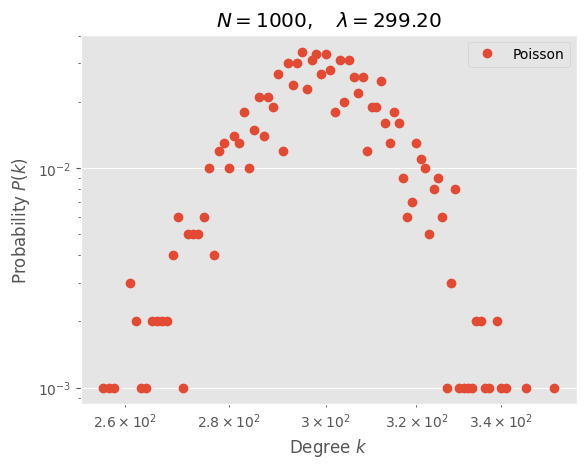

299.202
Random node faliure, 99%
Eliminated nodes = 990
number of conncted component = 1
Compute Robustness network


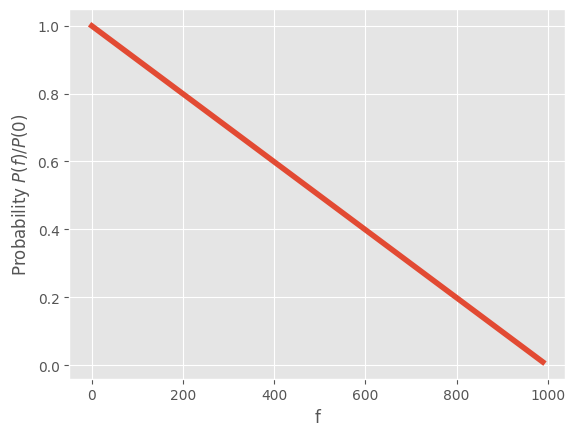

Compute Poisson fit
Draw Network


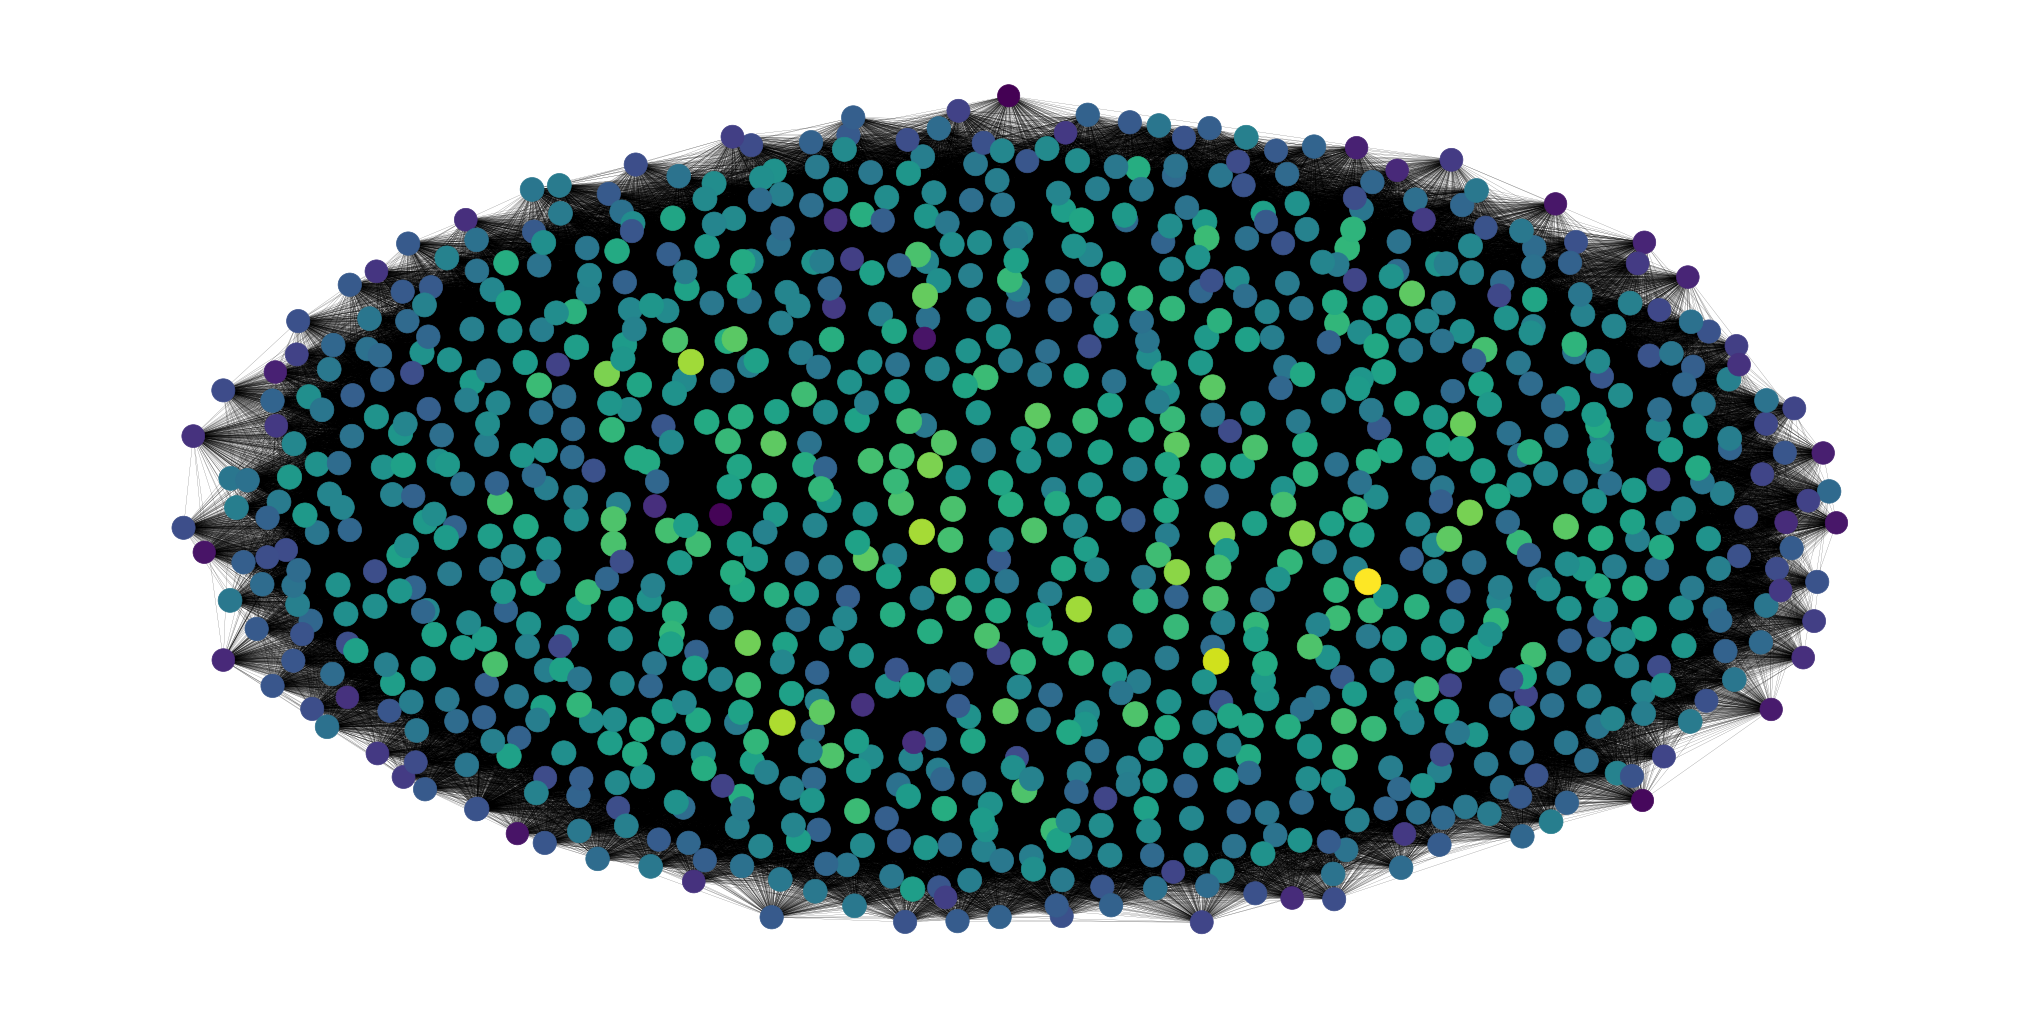

In [24]:
print("Artificial Random Network")

print("Generate random network")
network_poisson, lamb, param = generate_random_network_poisson(1000, 0.3)
draw_scale_poisson_distribution(network_poisson)
print(lamb)
print("Random node faliure, 99%")
_, P_inf_devided_P_0, f = loop_node_removal(network_poisson, 0.99)

print("Compute Robustness network")
robustness_plot(network_poisson, P_inf_devided_P_0, f)

print("Compute Poisson fit")


f_c = compute_fc_poisson(network_poisson, lamb):
print(f_c)

print("Draw Network")
draw_network(network_poisson, size=1)

In [25]:
o = graph_parameters(network_poisson, lamb)

Create Network
299.452
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 4
Compute Critical threshold
0.9966605666350533
Create Network
300.444
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 1
Compute Critical threshold
0.9966715927094567
Create Network
299.456
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 3
Compute Critical threshold
0.9966606112417183
Create Network
299.85
Simulate random faliures, 99% nodes
Eliminated nodes = 990
number of conncted component = 1
Compute Critical threshold
0.9966649991662498


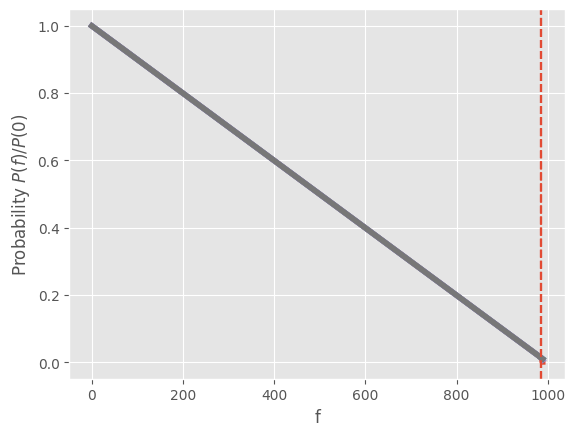

Create Network
600.819
Simulate random faliures, 99% nodes


In [26]:
ratios={}
for size in [1000, 2000, 5000]:
    ratios[size] = {}
    ratio = ratios[size]
    ratio["lamb"] = []
    ratio["params"] = []
    ratio["P_inf"] = []
    ratio["fc"] = []
    for i in range(4):
        seed = random.randint(0, 100000000000000000)
        print("Create Network")        
        network_poisson, lamb, params = generate_random_network_poisson(size, 0.3)
        ratio["lamb"].append(lamb)
        ratio["params"].append(params)
        print(lamb)

        print("Simulate random faliures, 99% nodes")
        network_removed, P_inf_devided_P_0, f = loop_node_removal(
            network_poisson, 0.99)
        
        ratio["P_inf"].append(P_inf_devided_P_0)

        print("Compute Critical threshold")
        fc = compute_pc_poisson(network_poisson, lamb)
        print(fc)
        ratio["fc"].append(fc)
        xnew = np.linspace(min(f), max(f), 200)

        #define spline with degree k=7
        spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
        y_smooth = spl(xnew)
        plt.plot(f, P_inf_devided_P_0, linewidth=4)
        plt.axvline(x=max(f)*fc, linestyle='--')
    
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.show()

#Protein to protein

In [ ]:

df = pd.read_csv('Protein-Interaction.txt',  sep= '\s+', header = None)
g = nx.Graph()
for i in range(len(df)):
    node=df.loc[i,:][0] 
    next_node=df.loc[i,:][1]  
    protein_protein.add_edges_from([(node,next_node)])

draw_network(g)



In [ ]:

import scipy.optimize as opt


def funct(x, alpha, x0):
    return((x+x0)**(-alpha))


node_degree = list(g.degree())  # list (node, degree)
degrees = []
interval = 0
print(node_degree[0])

for node, degree in node_degree:
    degrees.append(degree)
    interval += 1

degrees = np.array(degrees)
interval = np.array(list(range(interval)))

param_bounds = ([0, -np.inf], [np.inf, np.inf])
fit = opt.curve_fit(funct,
                    interval,
                    degrees,
                    bounds=param_bounds)

alpha, x0 = fit[0]
print(fit[0])

print(interval[0])

C = 1/integrate.quad(lambda t: funct(t, alpha, x0), 1, np.inf)[0]
pdf = [C*funct(x, alpha, x0) for x in interval]
sse = np.sum(np.power(degrees - pdf, 2.0))
print(sse)

fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(interval, degrees, basex=10, basey=10, linestyle='None',  marker='.')
ax.loglog(interval, pdf, basex=10, basey=10, linestyle='None',  marker='.')
